<center><h1> ST420: Statistical Learning and Big Data </h1></center>
    
<center><h2> Assignment 2:Bayesian classification </h2></center>
<center><h2> Gabija Vaisvilaite </h2></center>

Importing libraries.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

The following code was performed in r.

Setting up the data.

In [2]:
x_train = pd.read_csv('xtrain.csv')  
y_train = pd.read_csv('ytrain.csv')  
x_test = pd.read_csv('xtest.csv')  
y_test = pd.read_csv('ytest.csv') 

## 1.

Defining log likelihood function.

In [3]:
def log_likelihood(x_data, y_data, beta):
    value = 0
    size = np.shape(x_data)[0]
    for i in range(size):
        y = y_data.to_numpy()[i][0]
        x = x_data.to_numpy()[i]
        z = np.zeros(3)
        for j in range(3):
            z[j] = 1*beta[3*j] + x[0]*beta[3*j+1] + x[1]*beta[3*j+2]
        p = np.exp(z[y-1])/np.sum(np.exp(z))
        value += np.log(p)
    return value

Obtaining the log likelihood value of the training data with $\beta = (1,1,1,1,1,1,1,1,1)^T $.

In [4]:
log_likelihood(x_train, y_train, np.zeros(9)+1)

-163.69323101154808

## 2.

Defining functions to obtain $p$ and $q$ in the Metropolis-Hastings algorithm.

In [5]:
def log_prior(beta):
    return multivariate_normal(mean = np.zeros(9), cov = 100*np.eye(9)).logpdf(beta)

def log_proposal(beta_star, beta, cov):
    return multivariate_normal(mean = beta_star, cov = cov).logpdf(beta)

Defining Metropolis-Hastings algorithm with parameters $n$, i.e. number of iterations, and $cov$, i.e. the covariance matrix $\Sigma_q$.

In [6]:
def met_has(n,cov):
    beta = np.zeros((n,9))
    beta[0] = np.random.multivariate_normal(np.zeros(9), 100*np.eye(9))
    count = 0
    for i in range(1,n):
        beta_star = np.random.multivariate_normal(beta[i-1], cov)
        u = np.random.uniform(0,1)
        threshold = log_likelihood(x_train,y_train,beta_star) + log_prior(beta_star) +  log_proposal(beta_star, beta[i-1], cov) \
        - log_likelihood(x_train,y_train,beta[i-1]) - log_prior(beta[i-1]) - log_proposal(beta[i-1], beta_star, cov)
        if u < np.min([1, np.exp(threshold)]):
            beta[i] = beta_star
        else:
            beta[i] = beta[i-1]
            count += 1
    return beta

After performing the algorithm for various diagonal covariance matrices $\Sigma_q$ we have picked an initial matrix with idential diagonal values $0.05$. Now with such $cov$ we will run the algorithm to obtain the acceptance rate.

In [7]:
# n = 200000
# cov = 0.05*np.eye(9)
# betas_long = met_has(n,cov)

# np.savetxt(r"\Users\gabij\Desktop\R projects\betas2.csv", betas_long, delimiter=",")

# acc_rate = np.shape(np.unique(betas_long, axis=0))[0]/n
# acc_rate

In [8]:
n = 200000
betas_long = pd.read_csv(r"\Users\gabij\Desktop\R projects\betas2.csv")
acc_rate = np.shape(np.unique(betas_long.to_numpy(), axis=0))[0]/n
print (acc_rate)

0.078835


So the acceptance rate for such initial matrix is around $7.88\%$ Now to estimate the posterior $\Sigma_{\hat{\pi}}$ we use burn-in period of $100,000$ and obtain the tuned $\Sigma_q$ as follows.

In [9]:
x = 100000
betas = betas_long.to_numpy()[x: , :] # picking betas only after burn-in period
covariance = np.cov(betas.T, bias = True) # computing covariance
sigma_q = (2.38**2)*covariance/9 # setting the sigma_q

And with this covariance matrix we run the algorithm again.

In [10]:
# n = 200000
# opt_betas = met_has(n,sigma_q)

# np.savetxt(r"\Users\gabij\Desktop\R projects\betas_opt.csv", opt_betas, delimiter=",")

# acc_rate = np.shape(np.unique(opt_betas, axis=0))[0]/n
# acc_rate

In [11]:
n = 200000
opt_betas = pd.read_csv(r"\Users\gabij\Desktop\R projects\betas_opt.csv")
opt_betas = opt_betas.to_numpy()
acc_rate = np.shape(np.unique(opt_betas, axis=0))[0]/n
print (acc_rate)

0.3268


The acceptance rate with the tuned covariance matrix is then $32.7\%$.

## 3.

The following code was performed in R.

It gave us the ESS of 1090.9 and so after burn-in of 50,000 we used only 63,000 iterations to find such ESS.

## 4.

Plotting the histogram of the last coordinate of vector $\beta$. Here we only use as the betas after burn in and only until we reach ESS of 1000.

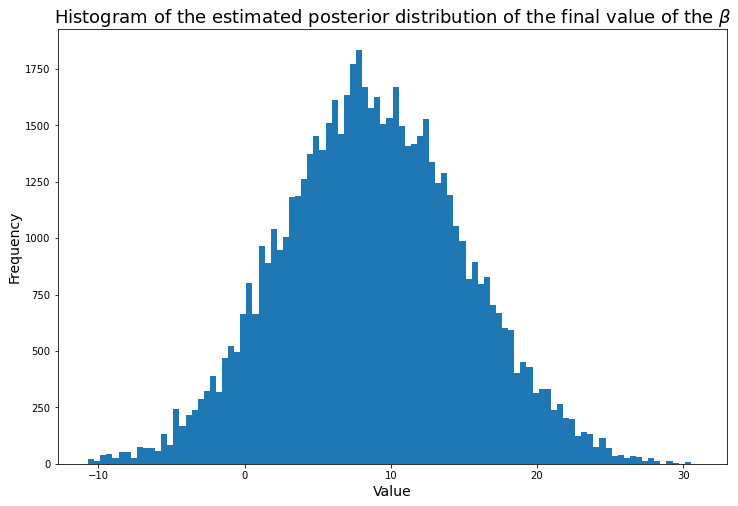

In [12]:
x = 50000
y = 113000
opt_betas_adj = opt_betas[x:y, :]
    
plt.rcParams['figure.figsize'] = [12, 8]
plt.xlabel(r'Value',fontsize = 14)
plt.ylabel(r'Frequency',fontsize = 14)
plt.title(r'Histogram of the estimated posterior distribution of the final value of the $\beta$',fontsize = 18)
plt.hist(opt_betas_adj[:,8], bins = 100)
plt.show()

The distribution looks normal and centered at around 8.

## 5.

We first compute the probabilities.

In [13]:
opt_betas_x = opt_betas[50000:,:]
size = np.shape(opt_betas_x)[0]
x = x_test.to_numpy()[0]
prob = np.zeros(size)
for i in range(size):
    beta = opt_betas_x[i]
    z = np.zeros(3)
    for j in range(3):
        z[j] = 1*beta[3*j] + x[0]*beta[3*j+1] + x[1]*beta[3*j+2]
    p = np.exp(z[0])/np.sum(np.exp(z))
    prob[i] = np.log(p)

And now we plot the required histogram.

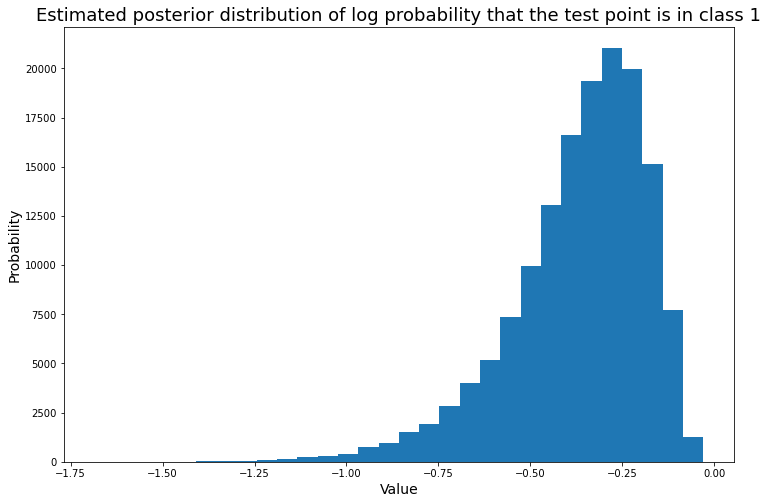

In [14]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.xlabel(r'Value',fontsize = 14)
plt.ylabel(r'Probability',fontsize = 14)
plt.title(r'Estimated posterior distribution of log probability that the test point is in class 1',fontsize = 18)
plt.hist(prob, bins = 30)
plt.show()

The log distribution is negatively skewed and has mean of around -0.3 (logged).

## 6.

An estimate for the expected probability that the test point is in class 1 under the posterior is:

In [15]:
beta_final = np.mean(opt_betas[50000:,:])
x = x_test.to_numpy()[0]
z = np.zeros(3)
for j in range(3):
    z[j] = 1*beta[3*j] + x[0]*beta[3*j+1] + x[1]*beta[3*j+2]
p = np.exp(z[0])/np.sum(np.exp(z))
p

0.8527833590506476